# **지능형 IoT 응용**
#### 한국기술교육대학교 컴퓨터공학부 스마트 IoT 트랙


---


# 05. 마이크로컨트롤러용 기초 모델 훈련

---

### Acknowledgement


이 자료는 다음 서적의 내용을 바탕으로 작성되었음
- 초소형 머신러닝 TinyML (4장), 피트 워든, 대니얼 시투나야케 지음, 맹윤호, 임지순 옮김, 한빛미디어

---

## 모델 구축과 훈련

1. 간단한 데이터셋 얻기
2. 딥러닝 모델 훈련시키기
3. 모델 성능 평가하기
4. 마이크로컨트롤러 장치에서 실행되도록 모델 변환하기
5. 마이크로컨트롤러 장치에서 추론하는 코드 작성하기
6. 코드를 바이너리로 빌드하기
7. 바이너리를 마이크로컨트롤러에 배포하기

## 5.1 만들고자 하는 시스템

### 목표
- x라는 값이 들어왔을 때 사인 함수의 결과값인 y를 예측할 수 있는 모델을 학습시키는 것

- x 값에 대한 사인 함수의 결과값은 직접 계산할 수 있지만 그렇게 하지 않고, 결과에 근접하는 근사치를 낼 수 있는 모델을 학습시킴으로써 머신러닝의 기본 원리를 살펴보는 것이 목적임
- 학습시킨 모델을 하드웨어 장치에서 실행하고 모델의 출력값을 사용하여 깜박이는 LED를 제어할 것임

## 5.2 머신러닝 도구
### 5.2.1 파이썬과 주피터 노트북
### 5.2.2 구글 코랩
- https://colab.research.google.com/notebooks/welcome.ipynb


### 5.2.3 텐서플로우와 케라스
- 텐서플로우는 머신러닝 모델을 구축, 훈련, 평가, 배포하기 위한 도구 모음
- 원래 구글에서 개발되었으나 현재는 전 세계 수천 명의 참여자가 구축하고 유지관리하는 오픈소스 프로젝트
- 머신러닝/딥러닝에서 가장 널리 사용되는 프레임워크
- 케라스: 딥러닝 네트워크를 쉽게 구축하고 훈련시킬 수 있는 텐서플로우의 고급 API
- 텐서플로우 라이트: 텐서플로우 모델을 모바일과 임베디드 장치에 배포하는 도구 세트


## 5.3 모델 구축하기

### 5.3.1 종속성 라이브러리 가져오기

In [1]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

import math

### 5.3.2 데이터 생성

- 사인 함수로 생성된 데이터를 모델링하도록 네트워크(인공 신경망)를 훈련시키기 위한 데이터셋 생성
 - 사인 값을 계산하고 거기에 노이즈(임의의 작은 수)를 추가함

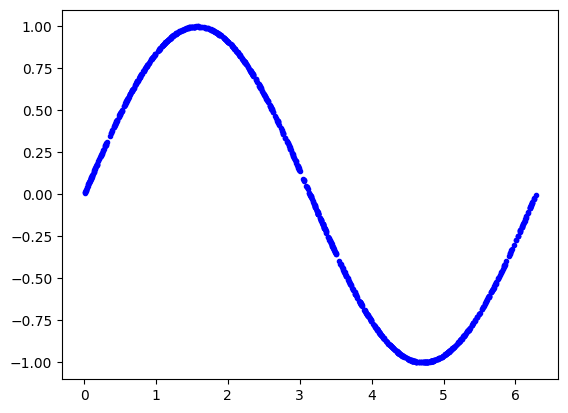

In [2]:
# numpy를 사용하여 난수를 생성하고 사인(sin)을 계산하는 코드

# 데이터 샘플 개수
SAMPLES = 1000

# 난수 생성시 사용될 시드값을 지정. 동일한 시드값을 사용하면 난수 생성 시 동일한 난수가 나옴
# 어떤 숫자든 사용할 수 있음
SEED = 777

#np.random.seed(0)
#print(np.random.randint(99, size=5))
#np.random.seed(0)
#print(np.random.randint(99, size=5))
#np.random.seed(1)
#print(np.random.randint(99, size=5))
#np.random.seed(1)
#print(np.random.randint(99, size=5))

np.random.seed(SEED)
tf.random.set_seed(SEED)

# 사인파 진폭의 범위인 0~2파이 내에서 균일하게 분포된 난수 집합을 생성
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# 값을 섞어서 생성된 값들의 순서를 바꿔줌
np.random.shuffle(x_values)

# 해당 사인 값을 계산
y_values = np.sin(x_values)

# 데이터를 그래프로 그림. 'b.' 인수는 라이브러리에 점을 파란색으로 출력하도록 지시
plt.plot(x_values, y_values, 'b.')
plt.show()


[-0.87323127  1.0376305  -0.42926174 -0.57031374 -1.95305696 -1.00943321]
(1000,)
1000
1000


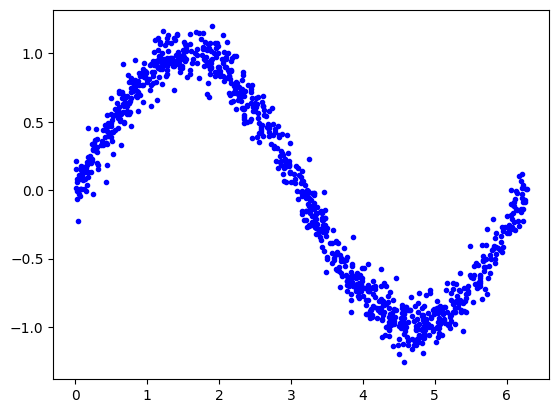

In [3]:
# 데이터에 임의로 노이즈를 추가한다

# 각 y 값에 임의로 작은 숫자를 추가한다.
y_values += 0.1 * np.random.randn(*y_values.shape) # randn : 평균 0, 표준편차 1의 가우시안 표준정규분표를 따르는 난수 array 생성

print(np.random.randn(6))
print(y_values.shape)
print(*y_values.shape)
print(*(1000, ))

# numpy random.randn 함수
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html
# *y_values.shape: 여기서 * 연산자는 언패킹 연산자로 사용. 함수에 인수로 전달하기 위해 배열의 형태를 개별 인수로 분해하는 역할
# NumPy 배열의 형태(shape)은 튜플로 표현됨 
# y_values.shape: (1000,)

# 그래프를 생성
plt.plot(x_values, y_values, 'b.')
plt.show()

### 5.3.3 데이터 분할

- 데이터셋 분할 : 훈련, 검증, 테스트 셋으로 분할
- 모델의 정확성을 평가하려면 예측을 실제 데이터와 비교하고 일치하는 정도를 확인해야 함
- 이 평가 절차는 훈련 중(검증)과 훈련 후(테스트)에 발생
- 모델 훈련에 사용되지 않은 데이터를 사용하는 것이 중요함


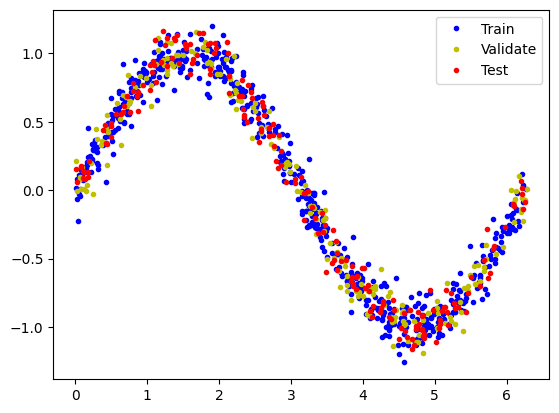

In [4]:
# 훈련에 60%, 테스트에 20%, 검증에 20% 사용

# 각 항목의 인덱스를 계산
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# np.split을 사용하여 데이터를 세 부분으로 자른다
# np.split의 두 번째 인수는 데이터가 분할되는 인덱스 배열
# 두 개의 인덱스를 제공하므로 데이터는 세 부분으로 나뉠 것임
x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# 분할한 데이터를 합쳤을 때 원래 사이즈와 같은지 다시 확인한다
assert(x_train.size + x_validate.size + x_test.size) == SAMPLES

# 분할된 각 데이터를 다른 색상으로 그래프에 표시
plt.plot(x_train, y_train, 'b.', label='Train') # 'b.' - blue
plt.plot(x_validate, y_validate, 'y.', label='Validate') # 'y.' - yellow
plt.plot(x_test, y_test, 'r.', label='Test') # 'r.' - red
plt.legend()
plt.show()


### 5.3.4 기본 모델 정의하기

- 입력값 x를 사용하여 숫자 출력값 sin(x)를 예측하는 모델을 구축할 것임
 - 이러한 유형의 문제를 회귀(regression)이라고 함

- 텐서플로우의 고수준 API인 keras를 사용함
 - 순차 모델 (Sequential): 뉴런의 각 레이어가 다음 레이어에 순차적으로 쌓이는 모델

 _____
- 첫번째 층
  - 단일 입력과 16개의 뉴런 (Dense layer, 혹은 fully connected layer)
  - 활성화 함수: ReLU (Rectified Linear Unit)
- 두번째 층
 - 단일 뉴런: 이전 레이어의 모든 활성화 값을 단일 출력으로 결합
 - 이 레이어는 출력 레이어이므로 활성화 함수를 거치지 않고 결과값을 그대로 출력



In [5]:
# 간단한 모델 구조를 만들기 위해 keras를 사용한다

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_1 = Sequential()

# 첫번째 레이어는 뉴런 16개로 스칼라 입력을 받아 다음 레이어에 전달한다
# 뉴런은 'relu' 활성화 함수에 따라 값을 전달할지 결정한다
model_1.add(Dense(16, activation='relu', input_shape=(1,)))

# 마지막 레이어는 뉴런이 하나 - 원하는 결과값이 하나이기 때문
model_1.add(Dense(1))

# 표준 옵티마이저와 손실을 사용하여 회귀 모델을 컴파일한다
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# 요약된 모델 설계를 출력한다
model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- param # : 가중치와 편향의 개수
 - 첫 번째 레이어에는 입력과 각 뉴런 사이에 하나씩 연결이 총 16개.
 - 둘째 레이어에는 뉴런이 하나 있고, 첫 번째 레이어의 각 뉴런에 하나씩 연결되는 연결이 총 16개.
 - 모두 합하면 총 32개의 연결 -> 가중치
 - 각 뉴런에 편향이 하나씩 총 17개 편향
 - 총 파라미터 32+17=49

## 5.4 모델 학습시키기

- fit() 함수 호출
 - x_train, y_train: 훈련 데이터의 x, y 값
 - epochs: 전체 훈련 데이터셋이 훈련 중 네트워크를 통해 몇 번이나 반복 실행될 것인지 지정
 - batch_size: 정확도를 측정하고 가중치와 편향을 업데이트하기 전에 네트워크에 공급할 훈련 데이터의 수를 지정. 16개의 데이터를 임의로 선택하여 추론을 실행해서 총 손실을 계산하고 배치당 네트워크를 한 번 업데이트하게 됨. 600개의 훈련 데이터가 있는 경우 epoch 당 약 38회 업데이트 됨.
 - validation_data: 검증 데이터셋을 지정.



In [6]:
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16, validation_data=(x_validate, y_validate))


Epoch 1/1000
38/38 [==============================] - 1s 6ms/step - loss: 7.1333 - mae: 2.4515 - val_loss: 5.0927 - val_mae: 2.0563
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 3.3347 - mae: 1.6715 - val_loss: 2.1328 - val_mae: 1.3227
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 1.2317 - mae: 0.9892 - val_loss: 0.6395 - val_mae: 0.6653
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.3830 - mae: 0.5066 - val_loss: 0.2557 - val_mae: 0.4248
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2411 - mae: 0.4209 - val_loss: 0.2274 - val_mae: 0.4112
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2199 - mae: 0.4053 - val_loss: 0.2131 - val_mae: 0.3988
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2014 - mae: 0.3882 - val_loss: 0.2014 - val_mae: 0.3876
Epoch 8/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.

### 5.4.1 훈련 지표
- loss: 손실 함수의 출력값. 위에서 mse (평균 제곱 오차)를 사용했음. 일반적으로 손실 값이 작을 수록 좋음. 7.1에서 0.13 정도로 줄어 훈련 중 개선되었음을 알 수 있음
- mae: 훈련 데이터의 평균 절대 오차. 네트워크 예측과 훈련 데이터 값 사이의 평균 차이를 나타냄. 2.5에서 0.28 수준.
- val_loss: 검증 데이터에 대한 손실 함수 출력. 훈련 데이터에 대한 손실보다 큼
- val_mae: 검증 데이터에 대한 평균 절대 오차. 훈련 데이터에 대한 오차보다 큼. 네트워크가 과대적합 되고 있다는 신호.

### 5.4.2 히스토리 개체 그래프로 나타내기



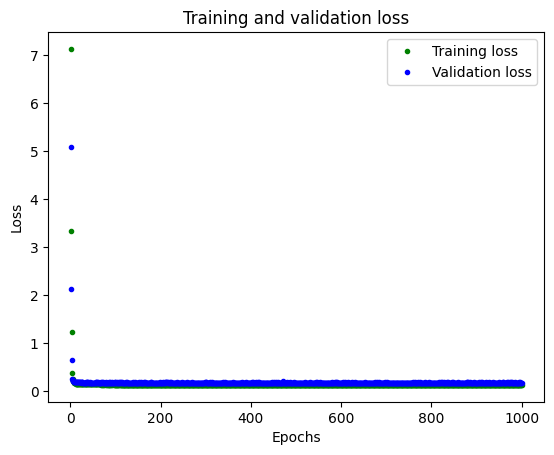

In [7]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

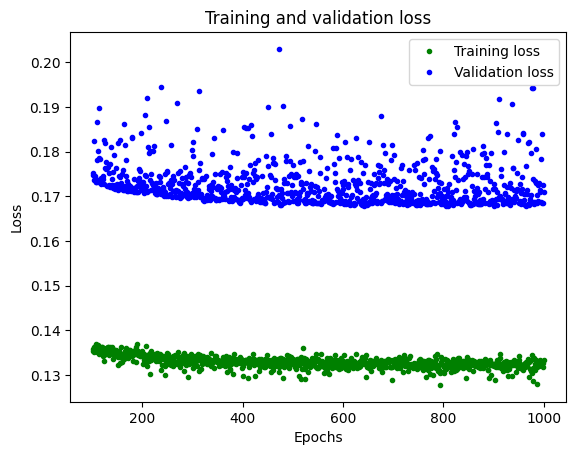

In [8]:
# 처음 100개의 에폭을 건너뛰어 그래프를 더 읽기 쉽게 만든다
SKIP = 100

plt.plot(epochs[SKIP: ], loss[SKIP: ], 'g.', label='Training loss')
plt.plot(epochs[SKIP: ], val_loss[SKIP: ], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

- 그래프를 통해 관찰할 수 있는 것
 - 에폭이 반복되어도 손실이 더 이상 줄어들지 않음
 - 검증 손실이 훈련 손실에 비해 꾸준히 더 큼
 - 손실값이 큼

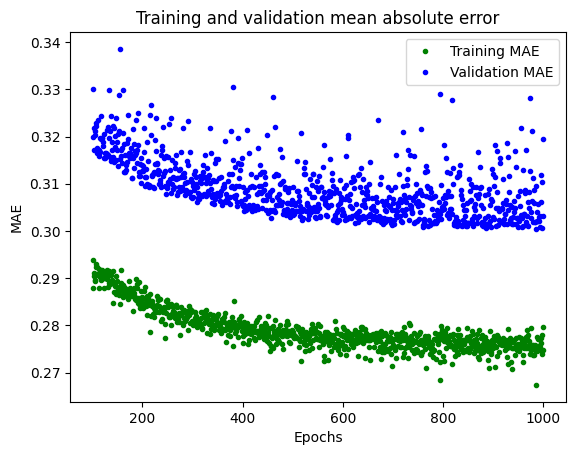

In [9]:
# 예측에서 오차를 측정하는 또 다른 방법인 평균 절대 오차 그래프를 그려보자

mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP: ], mae[SKIP: ], 'g.', label='Training MAE')
plt.plot(epochs[SKIP: ], val_mae[SKIP: ], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()



7/7 [==============================] - 0s 2ms/step


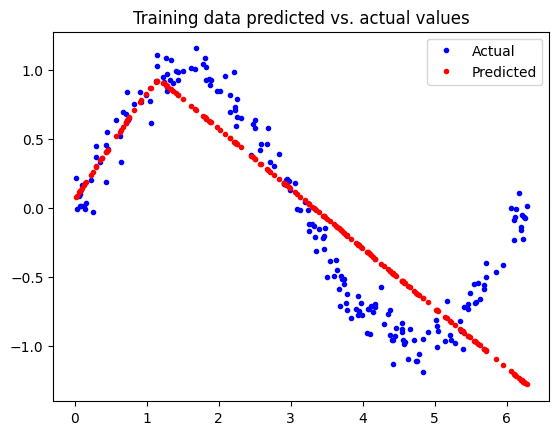

In [18]:
# 모델을 사용하여 검증 데이터로부터 예측값 생성

predictions = model_1.predict(x_validate)

# 테스트 데이터와 함께 예측값을 그래프로 표현
#plt.clf()
plt.title('Training data predicted vs. actual values')
plt.plot(x_validate, y_validate, 'b.', label='Actual')
plt.plot(x_validate, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

- 위 그래프에서 알 수 있는 것
 - 모델이 사인 함수를 매우 제한적인 방식으로만 근사하고 있음
 - 매끄러운 사인 곡선의 형태가 아니라 선형적으로 나타남

### 5.4.3 모델 개선하기

- 이전 모델은 너무 작아서 데이터의 복잡성을 학습하기 어려움
- 네트워크를 더 크게 만들어 모델을 개선할 수 있음
 - 쉬운 방법은 새로운 레이어를 추가하는 것

In [12]:
# 이전 모델과 같은 방식이나 중간에 16개의 뉴런을 갖는 층을 추가

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_2 = Sequential()

# 첫번째 레이어는 뉴런 16개로 스칼라 입력을 받아 다음 레이어에 전달한다
# 뉴런은 'relu' 활성화 함수에 따라 값을 전달할지 결정한다
model_2.add(Dense(16, activation='relu', input_shape=(1,)))

# 새로운 두 번째 레이어는 네트워크가 더 복잡한 표현을 학습하는데 도움을 준다
model_2.add(Dense(16, activation='relu'))

# 마지막 레이어는 뉴런이 하나 - 원하는 결과값이 하나이기 때문
model_2.add(Dense(1))

# 표준 옵티마이저와 손실을 사용하여 회귀 모델을 컴파일한다
model_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# 요약된 모델 설계를 출력한다
model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                32        
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 총 321개 파라미터
 - (1 x 16) + (16 x 16) + (16 x 1) = 288 개 가중치
 - 16 + 16 + 1 = 33 개 편향

In [13]:
history_2 = model_2.fit(x_train, y_train, epochs=600, batch_size=16, validation_data=(x_validate, y_validate))


Epoch 1/600
38/38 [==============================] - 1s 5ms/step - loss: 0.3847 - mae: 0.5356 - val_loss: 0.3095 - val_mae: 0.4735
Epoch 2/600
38/38 [==============================] - 0s 2ms/step - loss: 0.2999 - mae: 0.4697 - val_loss: 0.2586 - val_mae: 0.4442
Epoch 3/600
38/38 [==============================] - 0s 2ms/step - loss: 0.2403 - mae: 0.4225 - val_loss: 0.2156 - val_mae: 0.4070
Epoch 4/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1948 - mae: 0.3831 - val_loss: 0.1844 - val_mae: 0.3707
Epoch 5/600
38/38 [==============================] - 0s 3ms/step - loss: 0.1639 - mae: 0.3500 - val_loss: 0.1718 - val_mae: 0.3512
Epoch 6/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1471 - mae: 0.3281 - val_loss: 0.1670 - val_mae: 0.3374
Epoch 7/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1367 - mae: 0.3131 - val_loss: 0.1579 - val_mae: 0.3264
Epoch 8/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1288 - m

- 검증 손실이 0.17에서 0.012 정도로 1/10로 감소. 검증 mae가 0.3에서 0.086 정도로 감소하여 성능이 개선되었음을 알 수 있음

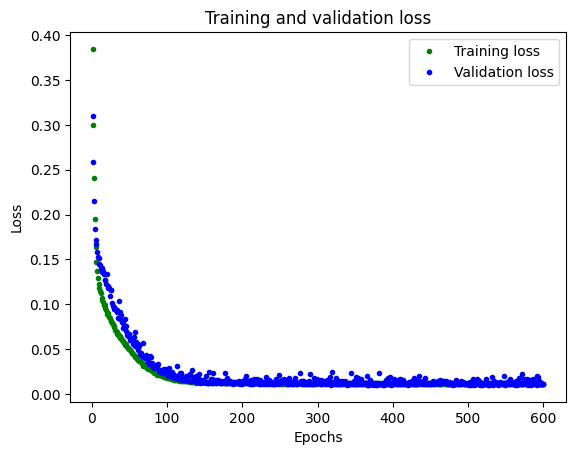

In [14]:
# 훈련과 검증 과정에서 예측값과 실제값 사이의 거리인 손실 그래프를 그린다

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

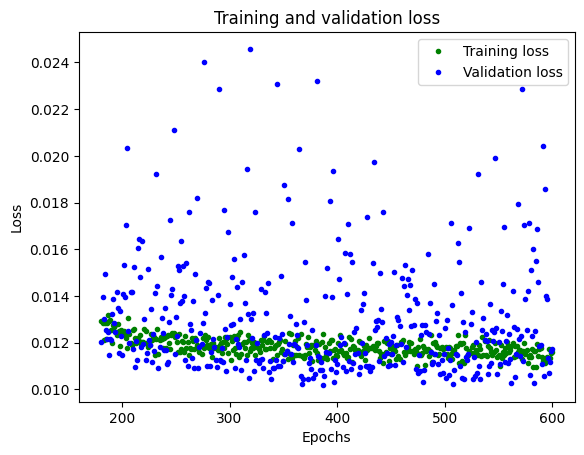

In [15]:
# 처음 에폭을 건너뛰어 그래프를 더 읽기 쉽게 만든다
SKIP = 180

plt.plot(epochs[SKIP: ], loss[SKIP: ], 'g.', label='Training loss')
plt.plot(epochs[SKIP: ], val_loss[SKIP: ], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

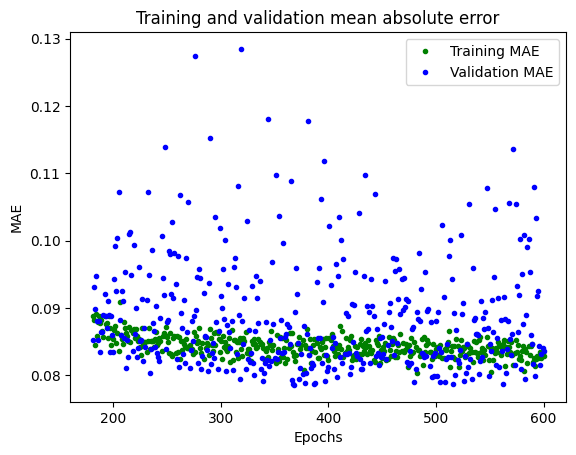

In [16]:
# 예측에서 오차를 측정하는 또 다른 방법인 평균 절대 오차 그래프를 그려보자

mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[SKIP: ], mae[SKIP: ], 'g.', label='Training MAE')
plt.plot(epochs[SKIP: ], val_mae[SKIP: ], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


- 지표의 절대값: 손실과 평균 절대 오차가 이전 네트워크보다 훨씬 나아졌음
- 훈련 지표와 검증 지표의 비교: 중간 중간 차이나는 것들이 있긴 하지만 대체적으로 검증 지표가 훈련 지표와 비슷한 값을 내고 있음.
 - 이전에 검증 지표가 훈련 지표보다 일정 수준 계속 크게 나왔음
- 검증 데이터를 보면 모델이 훌륭하게 작동하는 것처럼 보임. 이를 확인하기 위해 최종적으로 테스트를 실행해야 함

### 5.4.4 테스트

- 별도의 검증, 평가(테스트) 데이터를 가지고 있어야 함
 - 모델 학습 시 검증 데이터셋의 성능을 기반으로 네트워크를 미세 조정하기 때문에 새로운 데이터에 일반화하지 못할 위험이 있음
 - 테스트 데이터를 이용해 모델의 성능을 최종적으로 평가하여 이러한 상황이 발생하지 않았음을 확인해야 함
- 테스트 데이터를 사용하여 평가를 한 후에는 모델을 더 조정하면 안 됨
 - 테스트 데이터셋에 과적합할 수 있기 때문
- 테스트 데이터에서 모델이 제대로 작동하지 않으면 초기 레이어 설계 단계로 다시 돌아가야 함
 - 새로운 네트워크 아키텍처로 시도

7/7 [==============================] - 0s 2ms/step


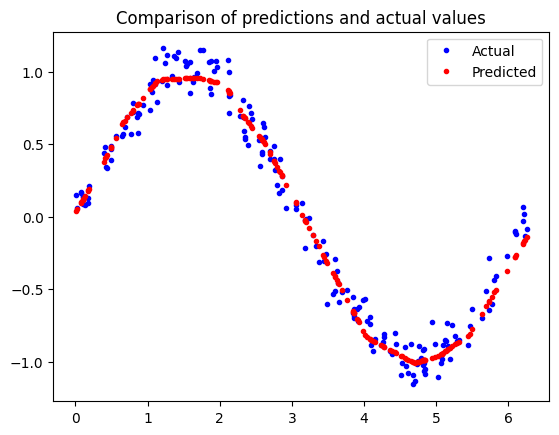

In [19]:
# 테스트 데이터셋의 손실 계산과 출력
loss = model_2.evaluate(x_test, y_test)


# 테스트 데이터셋 기반으로 예측
predictions = model_2.predict(x_test)

# 예측 결과 그래프
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label = 'Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()


- 손실 지표는 0.0107로 검증 손실과 유사, 평균 절대 오차도 0.0832로 검증 데이터에 대한 오차와 유사
- 이는 모델이 훌륭하게 작동하고 있으며 과대적합되지 않았다는 것을 의미함
 - 모델이 검증 데이터에 과대적합되면 테스트 데이터셋의 지표가 검증 데이터셋보다 훨씬 나쁘게 나왔을 것임
 - 과대적합 문제가 있다고 생각되면 일반화 기법을 사용하거나 더 많은 훈련 데이터를 확보하여 이를 해결할 수 있음

- 예측값을 나타낸 그래프를 보면 예측값이 실제값 분포 중심을 따라 나타나고 있음
 - 네트워크가 사인 곡선에 근접하는 법을 학습했음
 - 최고점과 최저점 부근에 실제 사인파처럼 완벽하게 매끄럽지는 않음
 - 우리의 목표는 LED를 부드럽게 켜고 끄는 것이므로 이것이 큰 문제는 아님


## 5.5 텐서플로우 라이트용 모델 변환

- 텐서플로우 라이트
 - 스마트폰, 마이크로컨트롤러 보드와 같은 에지 디바이스(edge device)에서 텐서플로우 모델을 실행하는 도구 모음
- 텐서플로우 라이트 2가지 구성 요소
 - 텐서플로우 라이트 변환기: 텐서플로우 모델을 메모리가 제한된 장치에서 사용하기 위해 공간 활용에 효율적인 특수한 포맷으로 변환. 모델 크기를 줄인 뒤 작은 장치에서 더 빨리 실행되도록 최적화도 적용할 수 있음
 - 텐서플로우 라이트 인터프리터: 주어진 장치에 가장 효율적인 연산을 사용하여 텐서플로우 라이트 모델을 실행

 ---
- 텐서플로우 라이트 변환기
 - 공간을 효율적으로 활용할 수 있게 설계된 특수 파일 형식인 플랫버퍼(FlatBuffer) 형식으로 구현된 케라스 모델을 디스크에 저장
 - 모델 최적화 수행: 모델의 크기나 실행 시간 또는 둘 다 줄임. 이 과정에서 정확도를 떨어뜨릴 수 있으나 최적화로 얻을 수 있는 이점이 큼
 - 양자화(Quantization): 유용한 최적화 방법 중 하나. 기본적으로 모델 가중치와 편향은 32비트 부동소수점 숫자로 저장하지만 양자화를 사용하면 이를 8비트 정수로 변환하여 크기를 감소. 또한 CPU는 부동소수점보다 정수로 계산하는 것이 더 쉽기 때문에 양자화된 모델이 더 빨리 실행될 수 있음.






In [26]:
### 양자화 없이 모델을 텐서플로우 라이트 형식으로 변환

converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

# 모델을 디스크에 저장
#open('./drive/MyDrive/sine_model.tflite', 'wb').write(tflite_model)
open('./sine_model.tflite', 'wb').write(tflite_model)


### 양자화하여 모델을 텐서플로우 라이트 형식으로 변환

converter = tf.lite.TFLiteConverter.from_keras_model(model_2)

# 양자화를 포함한 기본 최적화 수행
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 평가 데이터의 x값을 대표 데이터셋으로 제공하는 생성 함수를 정의하고 변환기에 이를 사용
def representative_dataset_generator():
  for value in x_test:
    # 각 스칼라 값은 반드시 리스트로 쌓여 있는 2차원 배열 안에 있어야 함
    yield [np.array(value, dtype=np.float32, ndmin=2)]

# full integer quantization을 위해 representative_dataset 속성을 설정
converter.representative_dataset = representative_dataset_generator

# 모델 변환
tflite_model = converter.convert()

# 모델을 디스크에 저장
#open('./drive/MyDrive/sine_model_quantized.tflite', 'wb').write(tflite_model)
open('./sine_model_quantized.tflite', 'wb').write(tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


3040

- keras 모델을 변환한 두 가지 버전
 - 첫 번째는 텐서플로우 라이트 플랫버퍼 형식으로 변환되지만 최적화는 하지 않음
 - 두 번째는 양자화를 진행

- 양자화된 모델이 가능한 한 효율적으로 실행되게 만들려면 모델이 학습한 데이터셋의 전체 입력값 범위를 나타내는 숫자의 집합인 대표 데이터셋 (representative dataset)을 제공해야 함
 - 평가 데이터셋의 x 값을 사용할 수 있음


- 텐서플로우 라이트 인터프리터
 - 텐서플로우 라이트로 변환된 모델을 사용하여 예측 수행

- 텐서플로우 라이트 인터프리터 사용하는 절차
 - 인터프리터 객체 인스턴스화
 - 모델에 메모리를 할당하는 메소드 호출
 - 입력 텐서에 입력값 작성
 - 모델 호출
 - 출력 텐서에서 출력값 읽기


[{'name': 'serving_default_dense_2_input:0', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


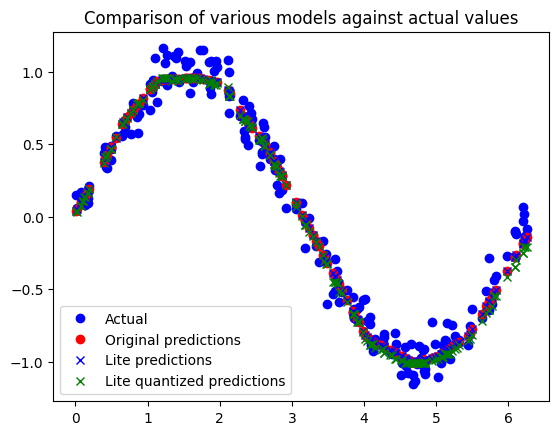

In [28]:
# 각 모델 인터프리터 인스터스화
#sine_model = tf.lite.Interpreter('./drive/MyDrive/sine_model.tflite')
#sine_model_quantized = tf.lite.Interpreter('./drive/MyDrive/sine_model_quantized.tflite')

sine_model = tf.lite.Interpreter('./sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('./sine_model_quantized.tflite')

# 각 모델에 메모리 할당
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# 입력과 출력 텐서 인덱스 가져오기
print(sine_model.get_input_details())

sine_model_input_index = sine_model.get_input_details()[0]['index']
sine_model_output_index = sine_model.get_output_details()[0]['index']

sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]['index']
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]['index']

# 결과를 저장하기 위한 배열 생성
sine_model_predictions = []
sine_model_quantized_predictions = []

# 테스트 데이터의 x 값에 대해 각 모델의 인터프리터를 실행하고 결과를 배열에 저장
for x_value in x_test:
  # 현재 값을 감싸고 있는 2차원 텐서 생성
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)

  # 값을 입력 텐서에 쓰기
  sine_model.set_tensor(sine_model_input_index, x_value_tensor)

  # 모델 호출하여 추론 실행
  sine_model.invoke()

  # 예측값을 출력 텐서에서 읽어서 결과 저장용 배열에 넣기
  sine_model_predictions.append(sine_model.get_tensor(sine_model_output_index)[0])


  ### 양자화된 모델에 대해서도 같은 작업 수행

  # 입력 텐서에 값 쓰기
  sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)

  # 모델 호출하여 추론 실행
  sine_model_quantized.invoke()

  # 예측값을 출력 텐서에서 읽어서 결과 저장용 배열에 넣기
  sine_model_quantized_predictions.append(sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])


# 결과 그래프 그려서 확인
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original predictions')
plt.plot(x_test, sine_model_predictions, 'bx', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()


- 그래프에서 원래 모델의 예측 값과, 변환된 모델, 양자화 변환된 모델의 예측값이 모두 구별할 수 없을 정도로 가까움을 알 수 있음

In [30]:
import os
#basic_model_size = os.path.getsize('./drive/MyDrive/sine_model.tflite')
basic_model_size = os.path.getsize('./sine_model.tflite')
print('Baisc model is %d bytes' %basic_model_size)

#quantized_model_size = os.path.getsize('./drive/MyDrive/sine_model_quantized.tflite')
quantized_model_size = os.path.getsize('sine_model_quantized.tflite')
print('Quantized model is %d bytes' %quantized_model_size)

difference = basic_model_size - quantized_model_size
print('Difference is %d bytes' %difference)

Baisc model is 3192 bytes
Quantized model is 3040 bytes
Difference is 152 bytes


- tflite로 변환된 모델과 양자화까지 수행한 변환 모델의 크기 차이는 약 150 바이트
 - 원래 모델 자체가 작기 때문에 파라미터 수가 많지 않아서 양자화를 한 모델의 크기 감소가 크지는 않음
 - 더 복잡한 모델은 더 많은 파라미터를 가지므로 양자화로 크기가 훨씬 더 절약됨

### 5.5.1 C 파일로 변환하기

- 마이크로컨트롤러용 텐서플로우 라이트와 함께 사용할 모델을 준비하는 마지막 단계
 - 모델을 애플리케이션에 포함할 수 있는 C 소스 파일로 변환하는 것
 - 파일에서 모델은 바이트 배열로 정의됨
 - xxd라는 유닉스 도구를 이용해 주어진 파일을 필요한 형식으로 변환할 수 있음


In [31]:
# xxd를 사용할 수 없을 때 설치한다
!apt-get -qq install xxd

# 파일을 C 소스 파일로 저장
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc

# 소스 파일 출력
!cat sine_model_quantized.cc

## 리눅스 쉘 명령어를 사용하기 위해서 !를 명령어 앞에 붙이면 됨

unsigned char sine_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00, 0xac, 0x03, 0x00, 0x00,
  0xbc, 0x03, 0x00, 0x00, 0x58, 0x0b, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0xfc, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff, 0x0b, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x34, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd6, 0xfc, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x0d, 0x00, 0x